In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [2]:
# ─── 1. LOAD DATA FROM EXCEL ────────────────────────────────────────────────────
# 1) Telling pandas “there is no header row” so every row is data, and columns get numeric names 0,1,2,...
df = pd.read_excel(
    r'C:\Users\Dell\data_reactor\500 ml\METHIONINE\0.1 wt %\NO PACK\nopack_0.1wt_methione_r1.xlsx',
    sheet_name=0,
    header=None
)

# 2) Pressure and Time
pressure_kPa = df[1]
time_s       = df[2]

# 3) Drop the rows that failed to parse as numbers
mask = pressure_kPa.notna() & time_s.notna()
pressure_kPa = pressure_kPa[mask].astype(float)
time_s       = time_s[mask].astype(float)

# 4) Units conversion
Pe_full = pressure_kPa.to_numpy() / 10.0     # → MPa
t_full  = time_s.to_numpy()       / 3600.0  # → hours

# Quick check
print("Pe_full (MPa):", Pe_full[:5])
print("t_full  (h) :", t_full[:5])

Pe_full (MPa): [7.512666 7.501985 7.492499 7.491289 7.481967]
t_full  (h) : [0.         0.00111111 0.00222222 0.00333333 0.00444444]


In [3]:
# ─── 2. CONSTANTS & THERMODYNAMIC PREP ─────────────────────────────────────────
Ar = np.pi * (0.075 ** 2) / 4
R  = 8.314

# peter atkins - physical chemistry
# Introduction to chemical engineering thermodynamics by J.M. Smith - page - 650+
Tc, Pc, w, T = 190.6, 4.599, 0.012, 274.15
Tr = T / Tc

# compressibility factor z (Pitzer)
a = (0.083 - 0.422*(Tc/T)**1.6)*(Tc/Pc)
b = w*(0.139 - 0.172*(Tc/T)**4.2)*(Tc/Pc)
z = 1 + a*(Pe_full/T) + b*(Pe_full/T)

# experimental moles (nexp)
v = 0.3674640599
n_water = 7.334773592
nd    = 5.75
nexp = ((7500000)/(0.828026351079252) - (Pe_full*1e6)/(z))*(v/(R*T)) # here nexp is in millimoles
nexp_full = ((nexp/n_water)*nd)/10

# fugacity coefficent & potentials (hydrate & liquid)
# pengrobinson eqn
m     = 0.37464 + 1.54226*w - 0.26992*w**2
alfa  = (m*(1 - np.sqrt(Tr)))**2
arel  = ((0.45724*(R*Tc)**2)/((Pc)*alfa))
brel  = 0.0778*R*Tc/(Pc)
A     = arel*(Pe_full)/(R*T)**2
B     = brel*(Pe_full)/(R*T)
fh    = np.exp(z - 1 - np.log(z - B)
             - A/(2*np.sqrt(2*B))
             * np.log((z+(1+np.sqrt(2))*B)/(z+(1-np.sqrt(2))*B)))
fg    = fh * Pe_full

# adsorption term (van der Waals p-model)
AsmL, BsmL = 3.7237e3, 2.7088e-3
Alar, Blar = 1.8372e2, 2.7379e-3
Csmall     = (AsmL/T)*np.exp(BsmL/T)
Clarge     = (Alar/T)*np.exp(Blar/T)
hydrate_pot      = (1/23)*np.log(1 + (Csmall*fg)) + (3/23)*np.log(1 + (Clarge*fg))

# thermochemical term
muo   = 1120
fterm = muo/(R*273.15)
#enthalpy = (
 #   -4297*(1/273.15 - 1/T)
  #  - 34.583*(np.log(T/273.15) + 273.15/T - 1)
   # + 0.189*(
    #    273.15*(np.log(273.15)-np.log(T))
     #   + (273.15**2)/(2*T + T/2 - 273.15)
#    )
#)
enthalpy = (1/8.314)*(np.log(T/273.15)*(-34.583 - 0.189*273.15) + (T - 273.15)*(0.189/2 + (0.189/2)*(273.15/T) + 34.583/T - 4297/(T*273.15)))
volume = (4.5959e-6*Pe_full*1e6)/(R*273.15)
gamma  = 1
xw     = (
    1
    - fg*np.exp(-15.8262 + 1559.0631/T)
         * np.exp(-(32*(Pe_full*9.86923 - 1))/(82.06*T))
)
liquid_pot = fterm - enthalpy + volume - np.log(xw*gamma)

# ΔF and RT_fit
DF_full = liquid_pot - hydrate_pot
RT_fit  = R * 274.15

In [4]:
# ─── 3. SPLIT INTO TRAIN / TEST ────────────────────────────────────────────────
np.random.seed(0)
N = len(nexp_full)
perm = np.random.permutation(N)
train_idx = perm[: int(0.8 * N)]
test_idx  = perm[int(0.8 * N):]

t_train, DF_train, y_train = t_full[train_idx], DF_full[train_idx], nexp_full[train_idx]
t_test,  DF_test,  y_test  = t_full[test_idx],  DF_full[test_idx],  nexp_full[test_idx]

In [5]:
# ─── 4. MODEL ──────────────────────────────────────────────────────────────────
def model_moles(params, DF, t):
    p, q, r, s = params
    expo = np.exp(-r / RT_fit)
    term = (p / nd) * (1 - np.exp(-nd * q * expo * (s / RT_fit)
                                   * Ar * DF * t * 3600))
    return term * nd * 100  # % water conversion


In [6]:
# ─── 5. NEG LOG‑POSTERIOR (MAP) ────────────────────────────────────────────────
priors = {
    'mean': np.array([0.5, 5000, 20000, 0.5, np.log(1.0)]),
    'var' : np.array([0.1**2, 2000**2, 1e4**2, 0.1**2, 1.0**2])
}

def neg_log_posterior(theta, DF, t, y):
    p, q, r, s, log_sigma = theta
    sigma = np.exp(log_sigma)
    y_pred = model_moles((p,q,r,s), DF, t)
    resid  = y - y_pred
    N      = len(y)
    nll    = 0.5*N*np.log(2*np.pi*sigma**2) + 0.5*np.sum(resid**2)/sigma**2
    diff = theta - priors['mean']
    nlp  = 0.5 * np.sum(diff**2 / priors['var'])
    return nll + nlp

In [7]:
# ─── 6. MAP FIT ────────────────────────────────────────────────────────────────
x0 = np.array([0.1, 150.0, 1000.0, 0.1, np.log(1.0)])
bounds = [(0,1),(10,1e5),(1,1e6),(0,1),(np.log(1e-6), np.log(1e2))]
res_map = minimize(neg_log_posterior, x0, args=(DF_train, t_train, y_train), bounds=bounds, method='L-BFGS-B')
params_map = res_map.x

# unpack
p_map, q_map, r_map, s_map, log_sigma_map = params_map
sigma_map = np.exp(log_sigma_map)
print("=== MAP PARAMETERS (train) ===")
print(f"p = {p_map:.4f}, q = {q_map:.2f}, r = {r_map:.2f}, s = {s_map:.4f}, σ = {sigma_map:.4f}")

=== MAP PARAMETERS (train) ===
p = 0.7812, q = 7231.99, r = 3126.46, s = 0.0337, σ = 1.9623


In [8]:
# ─── 7. PREDICT & EVALUATE ────────────────────────────────────────────────────
def mse(y_true, y_pred): return np.mean((y_true - y_pred)**2)
def rmse(y_true, y_pred): return np.sqrt(mse(y_true, y_pred))
def r2(y_true, y_pred): return 1 - np.sum((y_true - y_pred)**2)/np.sum((y_true - y_true.mean())**2)
def accuracy_pct(y_true, y_pred): return 100 - np.mean(np.abs((y_true - y_pred)/y_true))*100

y_pred_train = model_moles((p_map,q_map,r_map,s_map), DF_train, t_train)
y_pred_test  = model_moles((p_map,q_map,r_map,s_map), DF_test,  t_test)

print("\n=== TRAINING METRICS ===")
print(f"R² = {r2(y_train, y_pred_train):.4f}, MSE = {mse(y_train, y_pred_train):.4f}, RMSE = {rmse(y_train, y_pred_train):.4f}, Acc = {accuracy_pct(y_train, y_pred_train):.2f}%")
print("\n=== TEST METRICS ===")
print(f"R² = {r2(y_test, y_pred_test):.4f}, MSE = {mse(y_test, y_pred_test):.4f}, RMSE = {rmse(y_test, y_pred_test):.4f}, Acc = {accuracy_pct(y_test, y_pred_test):.2f}%")


=== TRAINING METRICS ===
R² = 0.9820, MSE = 3.8518, RMSE = 1.9626, Acc = 96.95%

=== TEST METRICS ===
R² = 0.9825, MSE = 3.8599, RMSE = 1.9647, Acc = 96.89%


In [9]:
# ─── 8. ADDITIONAL METRICS & PLOT ───────────────────────────────────────────────
tt = np.linspace(0, t_full.max(), 1000)
DF_interp = np.interp(tt, t_full, DF_full)
y_fit = model_moles((p_map,q_map,r_map,s_map), DF_interp, tt)

# t90: 90% of max fit
d_max = y_fit.max()
if d_max > 0:
    from numpy import interp as npi
    target = 0.9 * d_max
    t90 = npi(target, y_fit, tt)
    print(f"t90: {t90*3600:.1f}s ({t90:.3f}h) to reach {target:.2f}%")

# initial slope (%/hr) over first 900s
mask = (t_full*3600) <= 900
if mask.sum() > 1:
    slope = np.polyfit(t_full[mask], nexp_full[mask], 1)[0]
    print(f"Initial slope: {slope:.4f} %/hr")

# final conversion (<100%)
final_conv = y_fit[-1]
print(f"Final conversion: {final_conv:.4f} %")


t90: 6888.8s (1.914h) to reach 70.31%
Initial slope: 71.6285 %/hr
Final conversion: 78.1187 %


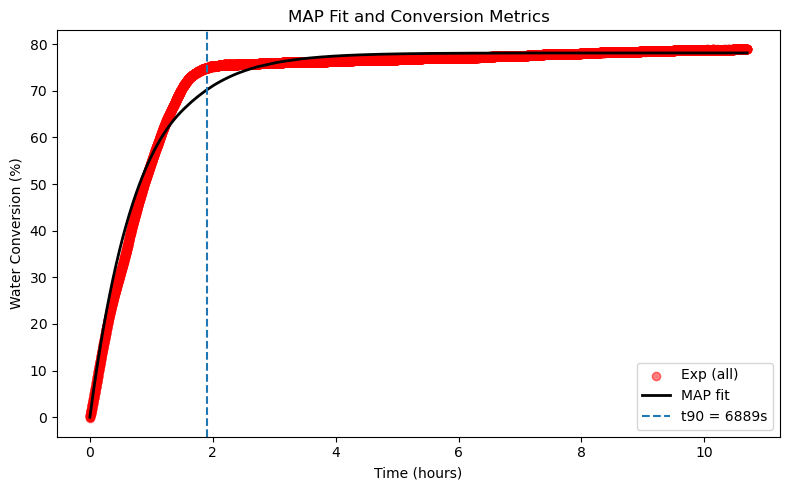

In [10]:
# ─── 9. PLOT ───────────────────────────────────────────────────────────────────
plt.figure(figsize=(8,5))
plt.scatter(t_full, nexp_full, color='red', alpha=0.5, label='Exp (all)')
plt.plot(tt, y_fit, color='black', lw=2, label='MAP fit')
if y_fit.max()>=d_max:
    plt.axvline(t90, linestyle='--', label=f't90 = {t90*3600:.0f}s')
plt.xlabel('Time (hours)')
plt.ylabel('Water Conversion (%)')
plt.title('MAP Fit and Conversion Metrics')
plt.legend()
plt.tight_layout()
plt.show()
